# Introduction to Verde

Unlike xESMF, verde is mainly designed around unstructured grids. Verde has a lot of great examples, we will use an atmospheric one below, but highly reccomend reading though the documents to get a better handle on the API.

https://www.fatiando.org/verde/latest/

### Prerequisites

Knowing your way around pandas, xarray, numpy and matplotlib is beneficial. This is not deisgned to be an introduction to any of those packages. We will be using Cartopy for some of the plots as well. 

# Imports

In [1]:
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cf

from appdirs import *

import verde as vd

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
%load_ext watermark
%watermark --iversions

sys       : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
cartopy   : 0.20.3
verde     : 1.7.0
pandas    : 1.4.3
matplotlib: 3.5.2
numpy     : 1.21.5



In [3]:
colnames=['remove', 'lon', 'lat', 'date', 'sensor', 'PM25value', 'sensor_type'] 

df = pd.read_csv('../data/airnow_data.csv', names=colnames, header=None)
df = df.drop(columns='remove')
df.head(3)

,lon,lat,date,sensor,PM25value,sensor_type
0,41.783083,-110.537888,2022-09-05T16:00,PM2.5,45,1
1,40.294300,-110.009000,2022-09-05T16:00,PM2.5,40,1
2,40.464722,-109.560830,2022-09-05T16:00,PM2.5,30,1


In [4]:
df.date = pd.to_datetime(df.date)
df.dtypes

lon                   float64
lat                   float64
date           datetime64[ns]
sensor                 object
PM25value               int64
sensor_type             int64
dtype: object

Let's pick a time that has decent coverage:

In [5]:
df.date.value_counts().head()

2022-09-05 16:00:00    36
2022-09-06 07:00:00    36
2022-09-06 20:00:00    36
2022-09-06 19:00:00    36
2022-09-06 18:00:00    36
Name: date, dtype: int64

In [6]:
df2 = df[df.date == '2022-09-06T07:00']
df2.head(3)

,lon,lat,date,sensor,PM25value,sensor_type
540,41.783083,-110.537888,2022-09-06 07:00:00,PM2.5,16,1
541,40.294300,-110.009000,2022-09-06 07:00:00,PM2.5,29,1
542,40.464722,-109.560830,2022-09-06 07:00:00,PM2.5,23,1


## Plotting the data

/Users/tmartin/opt/anaconda3/envs/ml_scratch/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/tmartin/opt/anaconda3/envs/ml_scratch/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


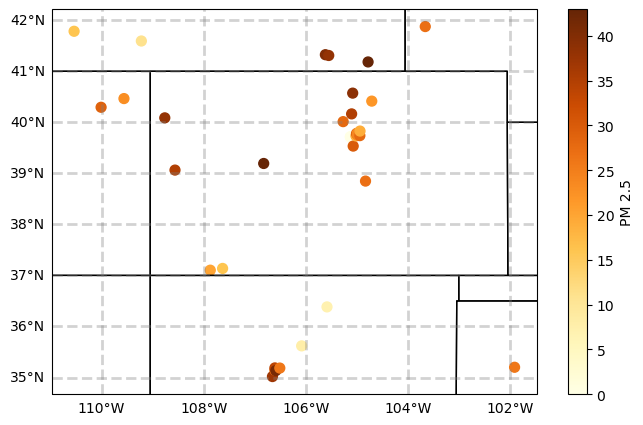

In [7]:
plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cf.STATES)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.35, linestyle='--')

gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-110, -108,  -106, -104, -102])

plt.scatter(df2.lat, 
            df2.lon, 
            c = df2.PM25value,
            s=50,
            cmap="YlOrBr")

plt.colorbar().set_label("PM 2.5")
plt.show()

# Verde Workflows

Some of these workflows might not work super well from a scientific standpoint, this is just to show the mechanics of the verde package. 

In [8]:
coordinates = (df2.lon, df2.lat)

### Trend Estimation

Same code, different example can be found here: https://www.fatiando.org/verde/latest/tutorials/trends.html

In [9]:
trend = vd.Trend(degree=1).fit(coordinates, df2.PM25value)
print(trend.coef_)

[38.39163129  0.54379964  0.32281663]


In [10]:
trend_values = trend.predict(coordinates)
residuals = df2.PM25value - trend_values

/Users/tmartin/opt/anaconda3/envs/ml_scratch/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


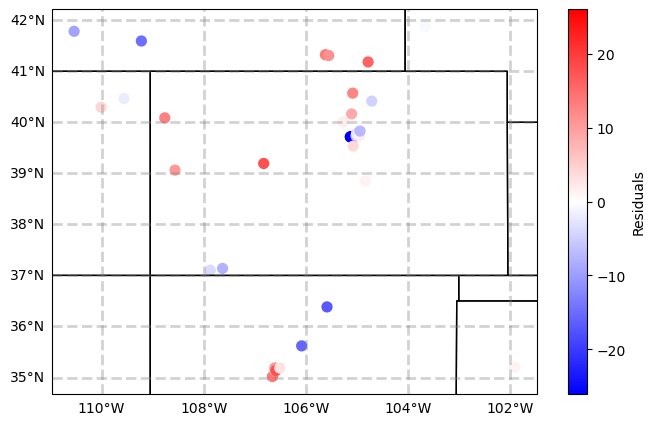

In [11]:
plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cf.STATES)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.35, linestyle='--')

gl.top_labels = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-110, -108,  -106, -104, -102])

maxabs = vd.maxabs(residuals)


plt.scatter(df2.lat, 
            df2.lon, 
            c = residuals,
            s=50,
            vmin=-maxabs,
            vmax=maxabs,
            cmap="bwr")

plt.colorbar().set_label("Residuals")
plt.show()

Unlike the Texas example in Verde, hard to see a distinct regional trend. 

### Data Decimation

In [12]:
spacing = 30 / 60 # Play around with this!

reducer = vd.BlockReduce(reduction=np.median, spacing= spacing)
print(reducer)

BlockReduce(reduction=<function median at 0x11089b550>, spacing=0.5)


In [13]:
filter_coords, filter_data = reducer.filter(
    coordinates=(df2.lat, df2.lon), data=df2.PM25value)

Sanity check

In [14]:
np.shape(filter_coords)[1] == np.size(filter_data)

True

Plotting the decimated datapoints

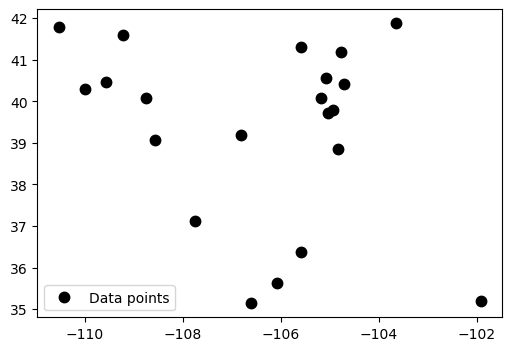

In [15]:
plt.figure(figsize=(6, 4))
plt.plot(*filter_coords, ".k",  markersize=15, label='Data points')
plt.legend()
plt.show()

### Verde Spline

This turtorial runs though this entire workflow, but with a bathymetery dataset: https://www.fatiando.org/verde/latest/tutorials/projections.html

In [16]:
spline = vd.Spline().fit(filter_coords, filter_data)

region = vd.get_region(filter_coords)
grid_coords = vd.grid_coordinates(region, spacing=spacing)
grid = spline.grid(coordinates=grid_coords, data_names="PM25")
print(grid)

<xarray.Dataset>
Dimensions:   (northing: 14, easting: 18)
Coordinates:
  * easting   (easting) float64 -110.5 -110.0 -109.5 ... -102.9 -102.4 -101.9
  * northing  (northing) float64 35.14 35.66 36.18 36.7 ... 40.84 41.36 41.88
Data variables:
    PM25      (northing, easting) float64 74.69 69.09 63.62 ... 11.73 6.292
Attributes:
    metadata:  Generated by Spline()


In [17]:
distance_mask = 1 #this might not make physical sense
grid = vd.distance_mask(filter_coords, maxdist=distance_mask, grid=grid)

Let's make a plot with the gridded and masked output, also shows where the datapoints are:

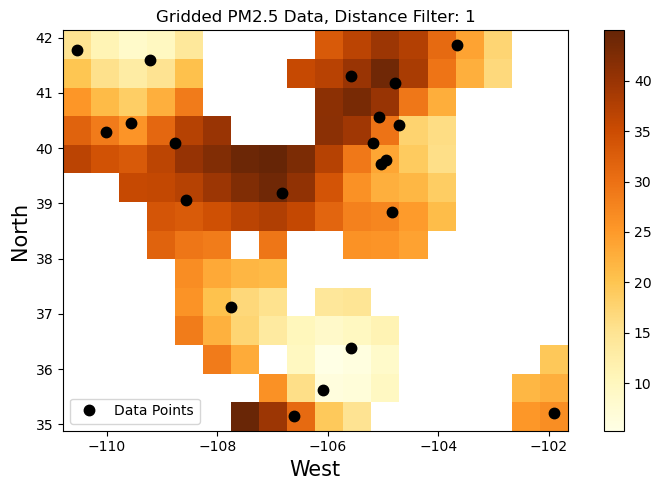

In [18]:
plt.figure(figsize=(8, 5))

pc = grid.PM25.plot.pcolormesh(cmap="YlOrBr", add_colorbar=False)
plt.colorbar(pc)
plt.plot(filter_coords[0], filter_coords[1], ".k", markersize=15, label='Data Points')

plt.title('Gridded PM2.5 Data, Distance Filter: '+str(distance_mask))

plt.xlabel("West", size=15)
plt.ylabel("North", size=15)
plt.legend()
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.show()

## Xarray

Making the grid into an xarray dataset is 1 line of code!

In [19]:
ds = grid.PM25.to_dataset()
ds

<xarray.Dataset>
Dimensions:   (easting: 18, northing: 14)
Coordinates:
  * easting   (easting) float64 -110.5 -110.0 -109.5 ... -102.9 -102.4 -101.9
  * northing  (northing) float64 35.14 35.66 36.18 36.7 ... 40.84 41.36 41.88
Data variables:
    PM25      (northing, easting) float64 nan nan nan nan ... 17.54 nan nan

Exporting this as a netCDF:

In [20]:
ds.to_netcdf('test.nc')

### Summary

Verde and xESMF are two different gridding packages, with two different aims. They both work well with xarray!